# Fixed bins controller: Combining particle-size distributions

This notebook explains the process of combining the different particle-size distributions within each image nest. For the creation of the particle-size distributions see Particle_sorter_worked_example for explanation of the Particle_sorter function.

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import DataFrame
import matplotlib.pyplot as plt
import math
import openpyxl
from glob import glob
#As explained in notebook Particle_sorter_worked_example
from Particle_sorter_perarea_fixedbins import Particle_sorter

#Explanation for these functions can be found in 
# Particle_sorter_worked_example as well as the .py file
from Particle_functions_area_fixedbins import bin_creator 
from Particle_functions_area_fixedbins import size_filter
from Particle_functions_area_fixedbins import normalise_data

from Particle_errors import IncorrectNumberOfFiles
from Particle_errors import MinBinTooBig
from textwrap import wrap
import os
import seaborn as sns

# 1. Inputting data

The code requires values for min_size_threshold, min_bin_size, and bin_multiplier to be inputted below.

Place the output .csv files from ImageJ for the image nest that you would like to combine into a folder. These files do not need to be processed before running this code. 
Give the name of the folder containing the files below (as file_path). 

The input .txt file needs to contain the names of the .csv files that you have placed in the folder, as well as the area of each image and its scale (see file_list.txt). An error will be raised if these do not match.

#### Note: Changing the titles of the individual columns in the .txt or .csv files (from ImageJ) inputted will break the code

In [2]:
min_size_threshold = 10 # Give minimum diameter of particles to consider
min_bin_size = 0.1 # Give the size of the lower bound of the smallest bin
bin_multiplier = 0.2 # Multiplier to make geometric bins

# Give the name of the .txt file containing the list of files,
# areas and scales
file_name = "file_list.txt" 

# Give folder name containing data files to be inputted.
# The outputs will be saved here. 
#Must be a folder within current working directory in 
# terminal unless you add a folder structure below.
file_path = "DM11B_55-57_data"

#Imports the information from the .txt file (file names, areas and scales)
file_list = pd.read_csv(f'{file_path}/{file_name}', sep = "\t") 
print(file_list)

# Takes all .csv files from the folder at the given file path
files = glob(f'{file_path}/*.csv') 
print("Data will be taken from the files:", files)


# Takes the columns from file_list and creates named variables
filenames = file_list["Filename"] 
im_areas = file_list["Image size"]
pix_per_ums = file_list["Scale"]

#Checks that the number of files found matches the number expected
# in the .txt file. 
#If these do not match then the error is raised.
if len(files) != len(filenames):
    raise IncorrectNumberOfFiles(len(files))
    
# Checks if output folder exists in current directory
if not os.path.exists(f'{file_path}/Output'): 
    # If does not exist, makes folder
    os.makedirs(f'{file_path}/Output') 

                   Filename  Image size    Scale
0   DM11B_55-57_x18k_30.csv    2703.284  21.2333
1   DM11B_55-57_x700_50.csv   16988.465   8.2800
2  DM11B_55-57_x220_200.csv  218878.308   2.5950
Data will be taken from the files: ['DM11B_55-57_data/DM11B_55-57_x18k_30.csv', 'DM11B_55-57_data/DM11B_55-57_x220_200.csv', 'DM11B_55-57_data/DM11B_55-57_x700_50.csv']


In [3]:
#To create a non-fixed bin size if needed
#min_bin = (min_size_threshold/(2*max(pix_per_ums)))**2*math.pi

#Sorts the data from the .txt file so that the images 
# are listed from high to low magnification
file_list.sort_values("Scale",ascending=False) 
file_list.reset_index(drop=True)

file_list

,Filename,Image size,Scale
0,DM11B_55-57_x18k_30.csv,2703.284,21.2333
1,DM11B_55-57_x700_50.csv,16988.465,8.2800
2,DM11B_55-57_x220_200.csv,218878.308,2.5950


# 2. Running the Particle_sorter function for each image within the nest

The Particle_sorter function processes each .csv file within the chosen folder in a loop. See Particle_sorter_worked example for explanation.

This function outputs the filtered and binned data that can then be combined to produce a single particle-size distribution for the image nest.

Below each filename will be outputted alongside information on the number of particles filtered out. A frequency distribution of each particle-size distribtution is also plotted, with n giving the number of particles remaining after filtering. This information is saved within the "_stats.csv" file outputted for each image. The plots are also outputted as "_raw_hist".

The code can be edited to produce different plots - the code for each plot is within the Particle_sorter function.

DM11B_55-57_x18k_30.csv
All data binned successfully
   Min particle area  Max particle area  No inputted particles  Inputted area  \
0           0.174203               27.0                    178          342.9   

   No too small  No too big  Total particles removed  \
0             0           0                        0   

   No particles after filtering  Area remaining particles  
0                           178                   342.879  
DM11B_55-57_x700_50.csv
All data binned successfully
   Min particle area  Max particle area  No inputted particles  Inputted area  \
0            1.14559              169.9                    198         3928.6   

   No too small  No too big  Total particles removed  \
0             1           1                        2   

   No particles after filtering  Area remaining particles  
0                           196                  3735.554  
DM11B_55-57_x220_200.csv
All data binned successfully
   Min particle area  Max particle area  No inpu

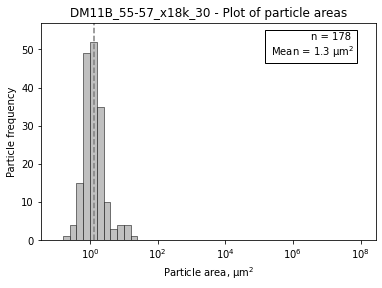

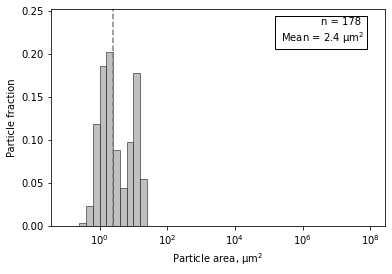

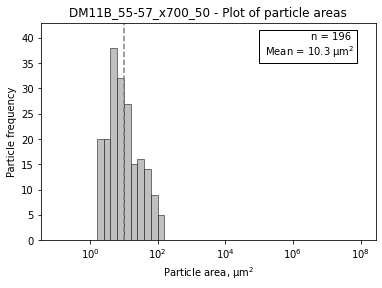

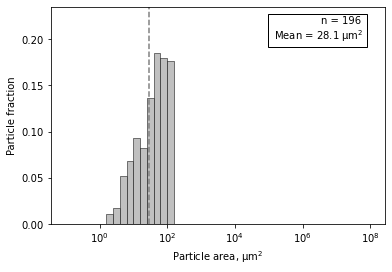

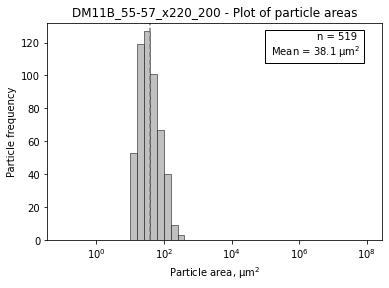

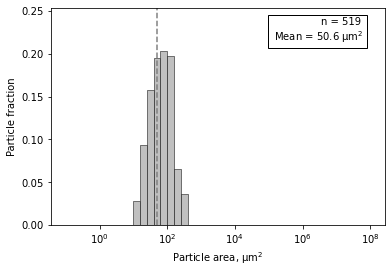

In [4]:
data_output = pd.DataFrame() #Creates empty dataframe to hold data
filtered_output = pd.DataFrame(index = range(1000))
no_filtered = np.zeros(len(filenames))
bin_counts = pd.DataFrame(index = range(45))
particles_too_big = np.zeros((len(filenames)))
total_inputted = 0
total_filtered_out = 0

# Creates loop to run the Particle_sorter function for the data 
# from each inputted file (runs once per image)
for i in range(0, len(filenames)):
    print(filenames[i])
    (bins_df, bins, filtered_data, area_too_big, stats) = \
    Particle_sorter(file_path, filenames[i], im_areas[i], \
                    pix_per_ums[i], min_size_threshold, \
                    min_bin_size, bin_multiplier)
    
    # Places the normalised output for each image/inputted 
    # file into the dataframe data_output 
    data_output[filenames[i]] = bins_df["Normal bin values"]
    bin_counts[filenames[i]] = bins_df["Counts"]
    print(stats)
    
    # Counts the number of filtered particles
    no_filtered[i] = len(filtered_data["Area"])
    # Creates an array of the number of particles that are too large
    particles_too_big[i] = area_too_big
    # Counts the total number of inputted particles
    total_inputted += sum(stats["No inputted particles"])
    #Places the filtered data into a dataframe filtered_output
    filtered_output[filenames[i]] = filtered_data["Area"]

# Calculates the total number of particles remaining after
# filtering across all images
particles_post_filter = sum(no_filtered)
# Calculates the number of particles removed
total_filtered_out = total_inputted - particles_post_filter 

print(f"The total number of particles inputted is {total_inputted}")
print(f"A total of {total_filtered_out} particles were filtered from \
the data leaving {particles_post_filter} particles for analysis")
    
# Converts the array of bin edges (bins) into 2 arrays that contain the 
# lower and upper bounds of each bin. These are placed into 
# the dataframe data_output
data_output["Bins lower"] = bins[:-1] 
data_output["Bins upper"] = bins[1:]
bin_counts["Bins lower"] = bins[:-1] 
bin_counts["Bins upper"] = bins[1:]

# Removes any empty rows created in the original dataframe
filtered_output = filtered_output.dropna(how = 'all')

# 3. Combining particle-size distributions

The particle-size distributions within each image nest need to be combined. This requires each particle-size distribution to be scaled.

## 3.1 Identifying cutoffs and cleaning the data
First, we can lay the unscaled distributions over each other to check how they align.

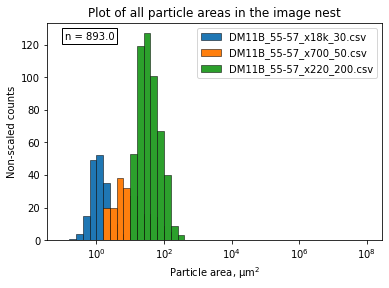

In [8]:
ax = plt.figure()
#Plots a histogram of the binned equivalent diameter data
for name in filenames:
    plt.hist(bins[:-1], bins, weights=bin_counts[name], \
             density = False, edgecolor='k', linewidth=0.5, \
             label=name) 
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
plt.ylabel("Non-scaled counts")
plt.title("Plot of all particle areas in the image nest")
plt.legend(loc='upper right')
ax.text(.28, .85, f"n = {particles_post_filter}", \
        horizontalalignment="right", verticalalignment="top", \
        bbox=dict(boxstyle = "square", facecolor = "white"))
plt.savefig(f'{file_path}/Output/unscaled_counts')

This plot looks at how the different particle fraction curves (normalised) align for each dataset. 

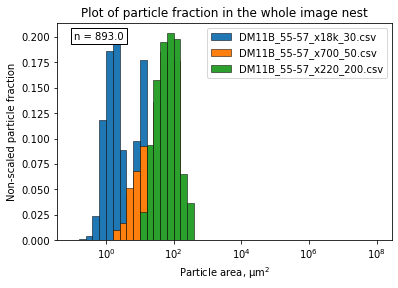

In [9]:
ax = plt.figure()
#Plots a histogram of the binned equivalent diameter data
for name in filenames:
    plt.hist(bins[:-1], bins, weights=data_output[name], \
             density = False, edgecolor='k', linewidth=0.5, \
             label=name) 
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
#plt.xlim([1, 10])
plt.ylabel("Non-scaled particle fraction")
plt.title("Plot of particle fraction in the whole image nest")
plt.legend(loc='upper right')
ax.text(.28, .85, f"n = {particles_post_filter}", \
        horizontalalignment="right", verticalalignment="top", \
        bbox=dict(boxstyle = "square", facecolor = "white"))
plt.savefig(f'{file_path}/Output/normalised__unscaled_counts')

Combining the datasets requires the bin values in each dataset to be the same. In the dataframe data_output the particle fraction data show that there are some bins that only contain data from one image, others multiple images.

The data needs cleaning to remove any rows that contain no data (so bins that contain no particles from any of the images).

In [10]:
data_output.head()

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv,Bins lower,Bins upper
0,0.000000,0.0,0.0,0.100000,0.158489
1,0.000732,0.0,0.0,0.158489,0.251189
2,0.004173,0.0,0.0,0.251189,0.398107
3,0.023686,0.0,0.0,0.398107,0.630957
4,0.118317,0.0,0.0,0.630957,1.000000


In [11]:
# Checks for rows in data_output that contain no data
f = (data_output[filenames].T != 0).any() 
f = f.where(f == True)

f =(f.dropna(how='all')) # Removes any rows that contain no data
index = f.index # Takes the index from f

# Uses the index from f to trim data_output, removing 
# rows with no data while keeping bins aligned
data_output = data_output.loc[index[0]:index[-1]] 
# Resets the index of data_output 
data_output = data_output.reset_index(drop = True) 
data_output.head()

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv,Bins lower,Bins upper
0,0.000732,0.0,0.0,0.158489,0.251189
1,0.004173,0.0,0.0,0.251189,0.398107
2,0.023686,0.0,0.0,0.398107,0.630957
3,0.118317,0.0,0.0,0.630957,1.000000
4,0.186218,0.0,0.0,1.000000,1.584893


## 3.2 Collecting the correct data from each image between cutoffs

The code combines the particle size distributions by switching from one curve to the next when the curve of the next magnification along exceeds the particle size fraction measured within a bin. This assumes that the next magnification has therefore imaged that particle size fraction better. This switching only occurs in one direction rather than continually switching back and forth between different curves.

First, we need to identify the image that has the maximum particle size fraction within each bin. This is then placed as a number in the dataframe (max_values) below.

In [12]:
# Gives the name of the column with the max value in that row
names=data_output[filenames].idxmax(axis=1)

# Creates new dataframe max_values containing names
max_values=pd.DataFrame(data = names, columns = ['Names'])

for i in range(len(filenames)):
    # Replaces the names with a numerical column value 
    # as named in the file "filenames"
    names = names.replace(to_replace = filenames[i], value=i) 
    
# Adds the number of the column with the maximum value 
# for each row to the dataframe
max_values["Column number"] = names 

max_values.head(10)


,Names,Column number
0,DM11B_55-57_x18k_30.csv,0
1,DM11B_55-57_x18k_30.csv,0
2,DM11B_55-57_x18k_30.csv,0
3,DM11B_55-57_x18k_30.csv,0
4,DM11B_55-57_x18k_30.csv,0
5,DM11B_55-57_x18k_30.csv,0
6,DM11B_55-57_x18k_30.csv,0
7,DM11B_55-57_x700_50.csv,1
8,DM11B_55-57_x18k_30.csv,0
9,DM11B_55-57_x18k_30.csv,0


The dataframe now contains the maximum value from each column. If we assume that the smaller particle sizes can only be better imaged by a larger magnification, then we want to only move from each image to the next magnification once rather than switching between images.

The code below creates an array (increasing) that contains the column numbers to take the data from for the final distirbution.

In [13]:
# Creates empty array to hold values from loop
increasing = np.zeros(len(names))
increasing[0] = 0 # Sets first value of array to zero

# Creates another empty array to hold values from loop
switch = np.zeros(len(names)) 

# Changes any column values that are not increasing, 
# so only moves from high mag to low mag image
for i in range(1,len(names)):
    if names[i] >= increasing[i-1]: 
        increasing[i] = int(names[i])
    else:
        # Array of integer column values that show which 
        # image provides data for each bin size 
        increasing[i] = int(increasing[i-1]) 
        
    if increasing[i] != increasing[i-1]:
        # If the number has changed, record as True in the array switch
        switch[i] = True 
        

In [14]:
# Changes values in increasing to integers
increasing = increasing.astype(int)

increasing

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

The array "increasing" now contains the number of the image that we would like to take the data from for each bin. The values in this array are now only increasing, and so we are only moving from each image to the next magnification once.

The code below now takes the data needed from each image between the cutoffs.

In [15]:
output = np.zeros(len(increasing)) # Creates empty array output

# Loop passes through the rows of data_output, 
# taking the value from the column given by the array increasing
for index, number in enumerate(increasing): 
    # Takes the desired values from data_output and places into output
    output[index] = data_output.iloc[index, number] 

# Places output array into the dataframe max_values
max_values["output"] = output

To help with filtering the data we need to collect the output values at which the particle size distribution switches from one dataset to another. These are then placed in the array switch_values_trim below. 

In [16]:
switch_values = np.zeros(len(switch)) # Creates array switch values

# Loop passes through switch and multiplies by output to only give 
# the output values where switching from one image to 
# another, rather than every value
for i in range(len(switch)):
    switch_values[i] = switch[i]*output[i]
    
    # Removes all zeros from array
    switch_values_trim = switch_values[switch_values != 0 ]  

max_values["switch values"] = switch_values # Places into dataframe
max_values["Increasing"] = increasing # Places into dataframe

# These are the values where switch from one 
# image to the next magnfication
switch_values_trim 

array([0.05182942, 0.09406573])

In [17]:
max_values.head()

,Names,Column number,output,switch values,Increasing
0,DM11B_55-57_x18k_30.csv,0,0.000732,0.0,0
1,DM11B_55-57_x18k_30.csv,0,0.004173,0.0,0
2,DM11B_55-57_x18k_30.csv,0,0.023686,0.0,0
3,DM11B_55-57_x18k_30.csv,0,0.118317,0.0,0
4,DM11B_55-57_x18k_30.csv,0,0.186218,0.0,0


Removing some of the data while combining the particle size distributions means that not all of the original particles are now included in the final distribution. By looking at the original data we can calculate the number of particles still included.

In [18]:
#Creates a new dataframe to hold the count data
post_bin_counts = np.zeros(len(output))

#Looks in the correct column in the original bin_counts data 
# to collect the number of particles present in that bin
for i,j in enumerate(max_values["Increasing"]): 
    post_bin_counts[i] = bin_counts.iloc[i,j]

# Finds the total number of particles still included in the distribution    
final_particle_number = round(sum(post_bin_counts))
print(f'The particle-size distribution now contains \
{final_particle_number} particles')

The particle-size distribution now contains 762 particles


To plot the distributions separately to see where they have combined we need to separate the particle-size distribution values back out into their original columns for each image.

In [19]:
# Creates new dataframe to hold the trimmed data
trim_output = pd.DataFrame()

# Gives indices at which switch from one image to the next
a = np.nonzero(switch_values)[0] 

# Creates array indexes that holds the index values at 
# which switch from one image to the next
indexes = np.zeros(len(a)+1)
for index, number in enumerate(a):
    indexes[index+1] = number


indexes = indexes.astype(int) # Makes sure array contains integers

# Creates new dataframe to hold the data split into images
split_max_values=pd.DataFrame(index=range(len(output)))

# Filters data to separate the max output values into the 
# image columns that they were taken from
for i in range(len(filenames)):
    filter_column=max_values['Increasing']==i
    split_max_values[filenames[i]]=max_values['output'][filter_column]

# Adds bin columns to dataframe
split_max_values["Bins lower"] = data_output["Bins lower"] 
split_max_values["Bins upper"] = data_output["Bins upper"]

split_max_values

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv,Bins lower,Bins upper
0,0.000732,NaN,NaN,0.158489,0.251189
1,0.004173,NaN,NaN,0.251189,0.398107
2,0.023686,NaN,NaN,0.398107,0.630957
3,0.118317,NaN,NaN,0.630957,1.000000
4,0.186218,NaN,NaN,1.000000,1.584893
5,0.202823,NaN,NaN,1.584893,2.511886
6,0.088895,NaN,NaN,2.511886,3.981072
7,NaN,0.051829,NaN,3.981072,6.309573
8,NaN,0.068174,NaN,6.309573,10.000000
9,NaN,0.092868,NaN,10.000000,15.848932


## 3.3 Calculating the remaining particle areas

Now that the data has been filtered it will need scaling. This scaling will be done by the area of particles measured in each image.

Here the original particle area data is refiltered to give only the particles that are still present in the final distribution.

In [20]:
# Creates empty array to hold loop output
order = np.zeros(len(indexes))

# confirms order that image data is in - only works for 
# increasing values, otherwise calls error
for i in range(0,len(indexes)):
    order[i] = max_values.at[(indexes[i]),"Column number"]
    
order

array([0., 1., 2.])

The bin values at which the final particle-size distribution seitches from one image to another are found. These then allow the original particle-size data to be refiltered to remove extra data.

In [21]:
# Finds the bin values at which need to switch from one image to the next.
# Creates new array to hold bin values
bin_filter = np.zeros((len(indexes)))
              
# Loop takes the bin values at which switch from one image to another
for i in range(0, len(indexes)):
    bin_filter[i] = split_max_values.at[(indexes[i]), "Bins lower"]

bin_filter = np.append(bin_filter, \
                split_max_values.at[len(split_max_values)-1, "Bins upper"])
bin_filter

array([1.58489319e-01, 3.98107171e+00, 1.58489319e+01, 3.98107171e+02])

To calculate the area of measured particles in each image the particles that are now too large (beyond the top cutoff) are removed.

In [22]:
# Creates new dataframe the length of filtered_output
too_big_post_cutoffs = pd.DataFrame(index=range(len(filtered_output)))

# Refilters the original particle area data 

# Removes particles that are too big (above the top cutoff for each image)
for i in range(len(bin_filter)-1): 
    
    # Places data column for each image into dataframe
    re_filtered = filtered_output[filenames[i]]
    
    # Removes values beyond top cutoffs
    re_filtered_filter=re_filtered > bin_filter[i+1]
    out = re_filtered[re_filtered_filter].dropna() # Removes Nas
    too_big_post_cutoffs[filenames[i]] = out.reset_index(drop = True)


too_big_post_cutoffs = too_big_post_cutoffs.dropna(how = 'all')
too_big_post_cutoffs # Contains the particles excluded for being too big

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv
0,5.694,51.912,NaN
1,15.794,23.090,NaN
2,4.134,22.783,NaN
3,18.937,72.230,NaN
4,14.217,53.298,NaN
5,9.872,17.532,NaN
6,15.085,155.546,NaN
7,15.810,31.083,NaN
8,6.907,35.298,NaN
9,8.369,21.762,NaN


In [23]:
# Creates empty array to place values for each image into
sum_too_big = np.zeros(len(filenames))

# Loop finds the total area of the remaining particles for each image
for i in range(len(filenames)):
    # Removes any NaNs from the array
    to_add = too_big_post_cutoffs[filenames[i]].dropna()
    sum_too_big[i] = sum(to_add) # Finds the sum of the array

sum_too_big # Area of particles removed for being too big

array([ 128.62 , 2836.983,    0.   ])

The data is then filtered to find the particles still present between each cutoff.

In [24]:
# Creates new dataframe to hold refiltered particle areas
refiltered_particles = pd.DataFrame(index=range(len(filtered_output)))

# Loop filters particles so that only those between the 
# cutoffs for each image remain (creating no size overlaps between images)
for i in range(len(bin_filter)-1): 
    # Places data column for each image into dataframe
    re_filtered = filtered_output[filenames[i]]
    
    # Filters between upper and lower cutoff
    re_filtered_filter= (re_filtered < bin_filter[i+1]) \
    & (re_filtered >= bin_filter[i]) 
    
    # Removes values beyond cutoffs
    out = re_filtered[re_filtered_filter].dropna()
    
    # Resets index so particles are placed into top of dataframe
    refiltered_particles[filenames[i]] = out.reset_index(drop = True) 

# Removes rows of all NaNs in the dataframe
refiltered_particles = refiltered_particles.dropna(how = "all") 
refiltered_particles

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv
0,0.688,12.500,31.927
1,0.399,10.371,295.811
2,2.848,7.876,48.411
3,0.366,10.852,27.175
4,2.010,4.653,23.166
...,...,...,...
461,NaN,NaN,19.899
462,NaN,NaN,17.968
463,NaN,NaN,38.016
464,NaN,NaN,22.275


The image of particles measured in each image between the cutoffs can then be calculated. This will be needed to scale the particle-size distributions.

In [25]:
image_particle_area = np.zeros(len(filenames))

for i in range(len(filenames)):
    # Removes any NaNs from the array
    to_add = refiltered_particles[filenames[i]].dropna() 
    image_particle_area[i] = sum(to_add) # Finds the sum of the array
    
image_particle_area

array([  214.259,   795.202, 24618.647])

## 1.4 Scaling the particle-size distributions to combine

Using the area of particles in each image and the working image area, we can estimate the effective porosity of each image. The area not made of particles is scaled to be filled by the particle size distribution from the image of the next greatest magnification.

The data is scaled from low to high magnification by the porosity each image.

In [26]:
# Removes particles >1% image area and those greater than the 
# upper size cutoff for each image
working_im_area = im_areas - particles_too_big - sum_too_big 

In [27]:
# Calculates the fraction of each image made from measured particles
particle_fraction = image_particle_area/working_im_area

# Calculates the fraction of each image not made from measured particles, 
# effectively the image porosity
im_porosities = 1 - particle_fraction 
im_porosities

0    0.916782
1    0.943031
2    0.887524
Name: Image size, dtype: float64

In [28]:
# Creates an empty array to place the porosities into
porosities = np.zeros(len(filenames))

# The image porosity of the highest magnification image 
# is the simply the porosity already calculated
porosities[0] = im_porosities[0] 

for i in range(1, len(filenames)):
    # Scales the porosities for the lower magnification images
    porosities[i] = im_porosities[i] * porosities[i-1] 
     
porosities # Contains the porosity values

array([0.91678176, 0.86455354, 0.76731166])

The filtered particle-size data for each image is now normalised again before scaling.

In [29]:
# Creates empty array and dataframe to hold values
total_norms = np.zeros(len(filenames)) 
scaled_values = pd.DataFrame()

for i in range(len(filenames)):
    norms = split_max_values[filenames[i]] 
    
    # Removes the NaNs from the normalised values of one image column
    total_norms[i] = sum(norms.dropna())
    
    # Normalises particle fraction and scales to make up the fraction 
    # of the image that is actually particles
    scaled_values[filenames[i]] = norms/total_norms[i] * \
    particle_fraction[i] 

scaled_values.head() # Contains the scaled values for each image

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv
0,0.000097,NaN,NaN
1,0.000556,NaN,NaN
2,0.003155,NaN,NaN
3,0.015758,NaN,NaN
4,0.024801,NaN,NaN


In [30]:
# Creates new dataframe to hold the NaN-removed data
scaled_values_squish = pd.DataFrame()

for name in filenames:
    # Moves all values to the top of the dataframe
    scaled_values_squish[name] = scaled_values[name].dropna\
    (how = "all").reset_index(drop = True)

# Removes unnecessary NANs to create trimmed dataframe
scaled_values_squish = scaled_values_squish.dropna(how = "all")
scaled_values_squish

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv
0,0.000097,0.013871,0.011136
1,0.000556,0.018245,0.018644
2,0.003155,0.024853,0.023130
3,0.015758,NaN,0.024112
4,0.024801,NaN,0.023432
5,0.027012,NaN,0.007731
6,0.011839,NaN,0.004291


The data is then scaled by the porosities, starting at the lowest magnification. This first data is not scaled and so can be placed straight into the final dataframe.

In [31]:
# Creates new dataframe
particles = pd.DataFrame(index=range(100))

# Places data from highest magnification image into the dataframe
particles[0] = scaled_values[filenames[order[0]]] 
particles.head()

,0
0,0.000097
1,0.000556
2,0.003155
3,0.015758
4,0.024801


Each subsequent image is then scaled by the porosity of the previous image, going from lowest to highest magnification.

In [32]:
for i in range(1,len(filenames)):
    # Scales the particle data by the image porosity
    accumulating = particles[i-1] * im_porosities[i]
    
    # Adds the data from the next image to the array
    accumulating = np.append(accumulating.dropna(), \
                             scaled_values[filenames[order[i]]].dropna()) 
    
    a = pd.Series(accumulating)
    
    # Adds the new column to the dataframe
    particles = pd.concat([particles, a], ignore_index=True, axis =1)

particles.head()

,0,1,2
0,0.000097,0.000092,0.000082
1,0.000556,0.000524,0.000465
2,0.003155,0.002975,0.002640
3,0.015758,0.014860,0.013189
4,0.024801,0.023388,0.020757


The distributions are then combined to produce one distribution. This distribution is then normalised.

In [33]:
# Creates new dataframe to hold the combined particle size distributions
combined_distributions = pd.DataFrame(index = range(100))

for i in range(len(filenames)):
    # Adds particle distributions with file names to the dataframe
    combined_distributions[filenames[order[i]]] = particles[i] 

# Removes any rows that are all NANs
combined_distributions = combined_distributions.dropna(how = "all")

# Takes final data column containing entire combined distribution
to_normalise = combined_distributions[filenames[order[-1]]] 

# Adds upper and lower bin edges to dataframe
combined_distributions["Bins lower"] = data_output["Bins lower"]
combined_distributions["Bins upper"] = data_output["Bins upper"]

In [34]:
#Normalises the distribution so adds to 1

# Finds N_A (number density per area
a = to_normalise/\
((combined_distributions["Bins upper"]+\
  combined_distributions["Bins lower"])/2)

norm_counts = a/sum(a)

sum(norm_counts)

combined_distributions["Normalised combined"] = norm_counts

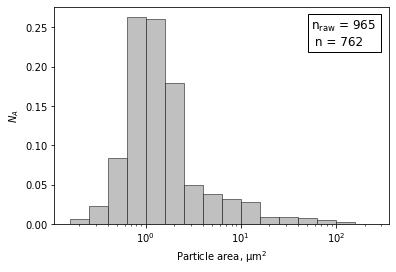

In [35]:
#Plots the binned data
ax = plt.figure()
plt.hist(combined_distributions["Bins lower"],\
         combined_distributions["Bins lower"] , \
         weights=combined_distributions["Normalised combined"], \
         color = 'Silver', edgecolor='k', linewidth=0.5, \
         density=False)
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
plt.ylabel("$N_A$")
text = "$\mathregular{n_{raw}}$"
ax.text(.72, .84, f"{text} = {total_inputted} \n n = \
{final_particle_number}", horizontalalignment="left", \
        verticalalignment="top", bbox=dict(boxstyle = "square",
                  facecolor = "white"), size = 12)
plt.title=("DM9B_1-3_data")
plt.savefig(f'{file_path}/Output/{file_path}_N_A.jpg')

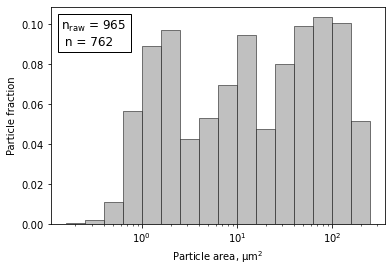

In [36]:
area_fraction = to_normalise/sum(to_normalise)

ax = plt.figure()
plt.hist(combined_distributions["Bins lower"],\
         combined_distributions["Bins lower"] , \
         weights=area_fraction, \
         color = 'Silver', edgecolor='k', linewidth=0.5, \
         density=False)
plt.xscale('log')
plt.xlabel("Particle area, $\mathregular{\mu m^{2}}$")
plt.ylabel("Particle fraction")
text = "$\mathregular{n_{raw}}$"
ax.text(.15, .84, f"{text} = {total_inputted} \n n = \
{final_particle_number}", horizontalalignment="left", \
        verticalalignment="top", bbox=dict(boxstyle = "square",
                  facecolor = "white"), size = 12)
plt.title=("DM9B_1-3_data")
plt.savefig(f'{file_path}/Output/{file_path}_area_fraction.jpg')

/var/folders/lm/0j023l013vx44_7p_mm1fsr80000gn/T/ipykernel_4918/948432665.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs_flat[3].set_xlim([0,max(combined_distributions["Bins lower"])])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will 

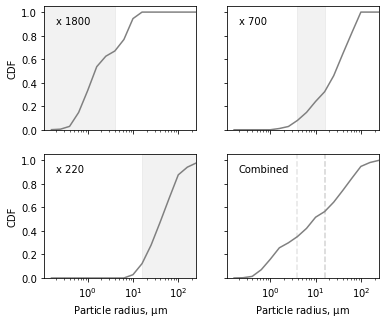

In [98]:
from matplotlib.patches import Rectangle

fig,axs=plt.subplots(ncols=2,nrows=2,sharex=True, sharey=True, figsize=(6,5))
axs_flat=axs.flat
for i in [0,1,2]:
    data_np = data_output.iloc[:,i]
    cdf = np.cumsum(data_np)

    axs_flat[i].plot(data_output["Bins lower"], cdf, color='grey')

    axs_flat[i].set_xscale('log')
    #axs_flat[i].set_xlim([0,100])

axs[0,0].set(ylabel='CDF')
axs[1,0].set(xlabel='Particle radius, $\mathregular{\mu m}$',ylabel='CDF')
axs[1,1].set(xlabel='Particle radius, $\mathregular{\mu m}$')

#axs[0,0].axvline(3.98, linestyle='dashed', color='silver')

#axs[0,1].axvline(3.98, linestyle='dashed', color='silver')
#axs[0,1].axvline(15.85, linestyle='dashed', color='silver')

#axs[1,0].axvline(15.85, linestyle='dashed', color='silver')

axs[1,1].axvline(3.98, linestyle='dashed', color='silver', alpha = 0.4)
axs[1,1].axvline(15.85, linestyle='dashed', color='silver', alpha = 0.4)

axs[1,1].axvline(15.85, linestyle='dashed', color='silver', alpha = 0.4)

axs[0,0].add_patch(Rectangle((0,0), 3.98, 1.05, angle=0.0, alpha = 0.2, color='silver'))
axs[0,1].add_patch(Rectangle((3.98,0), (15.85-3.98), 1.05, angle=0.0, alpha = 0.2, color='silver'))
axs[1,0].add_patch(Rectangle((15.85,0), (max(combined_distributions["Bins lower"])-15.85), 1.05, angle=0.0, alpha = 0.2, color='silver'))

cdf = np.cumsum(area_fraction)

axs_flat[3].plot(combined_distributions["Bins lower"], cdf, color='grey')

axs_flat[3].set_xscale('log')
axs_flat[3].set_xlim([0,max(combined_distributions["Bins lower"])])
axs_flat[3].set_ylim([0,1.05])

axs[0,0].text(0.2,0.9,"x 1800")
axs[0,1].text(0.2,0.9,"x 700")
axs[1,0].text(0.2,0.9,"x 220")
axs[1,1].text(0.2,0.9,"Combined")

plt.savefig(f'{file_path}/Output/{file_path}_cdf.eps')

In [61]:
split_max_values

,DM11B_55-57_x18k_30.csv,DM11B_55-57_x700_50.csv,DM11B_55-57_x220_200.csv,Bins lower,Bins upper
0,0.000732,NaN,NaN,0.158489,0.251189
1,0.004173,NaN,NaN,0.251189,0.398107
2,0.023686,NaN,NaN,0.398107,0.630957
3,0.118317,NaN,NaN,0.630957,1.000000
4,0.186218,NaN,NaN,1.000000,1.584893
5,0.202823,NaN,NaN,1.584893,2.511886
6,0.088895,NaN,NaN,2.511886,3.981072
7,NaN,0.051829,NaN,3.981072,6.309573
8,NaN,0.068174,NaN,6.309573,10.000000
9,NaN,0.092868,NaN,10.000000,15.848932


## 3.5 Stereological conversion

Now that the particle-size distribution has been produced from the image nest it can be converted to consider 3D particles rather than 2D intersection sizes.

In [38]:
# Calculates equivalent particle radius of each bin from the area
r_bin_lower = (combined_distributions["Bins lower"]/math.pi)**0.5 
r_bin_upper = (combined_distributions["Bins upper"]/math.pi)**0.5

v_bins_lower = (4/3)*math.pi*r_bin_lower**3 # Converts to volume bins
v_bins_upper = (4/3)*math.pi*r_bin_upper**3 # Converts to volume bins

r_bin_lower
stereo = pd.DataFrame()

In [39]:
# Creates array of zeros to hold the calculated normalised bin edges
nbins = np.zeros(len(combined_distributions)+1)
nbins[0] = 1 # The upper bound of the largest bin is 1.

# Loop creates the array of normalised bin edges, 
# each 10^(-0.1) smaller than the last
for i in range(0, len(nbins)-1): 
    nbins[i+1] = nbins[i] * 10**-(bin_multiplier)
    
# Splits the normalised bin edges into lower 
# and upper bounds for each bin
nbins_lower = nbins[1:] 
nbins_upper = nbins[:-1]

In [40]:
# # Creates an array of zeros for the calculated H_bar values to be added
H_bar = np.zeros(len(nbins)-1)

# Calculates the value of H_bar for each volume bin from 
# its upper and lower bounds
for index in range(len(nbins)-1): 
    H_bar[index] = ((v_bins_lower[index] + v_bins_upper[index])/2)**(1/3)
    
# Creates an array of zeros to hold the probability values
P = np.zeros(len(H_bar))

# Calculates the probablity value for each normalised bin 
# and places in the array P
for index in range(len(nbins)-1): 
    P[index] = -math.sqrt( 1 - nbins_upper[index]**2) + \
    math.sqrt( 1 - nbins_lower[index]**2)

    
# Inverts the volume bin bounds to order from largest 
# to smallest before placing in the stereo dataframe
stereo["v bins lower"] = np.flip(v_bins_lower) 
stereo["v bins upper"] = np.flip(v_bins_upper)

# Resets the dataframe index so that the values corresponding 
# to the largest bins are now at index 0.
stereo.reset_index(inplace = True, drop = True) 

# Adds the arrays of lower and upper normalised bin bounds 
# to the stereo dataframe
stereo["n bins lower"] = nbins_lower 
stereo["n bins upper"] = nbins_upper

# Inverts the H_bar column so that the values corresponding 
# to the largest bins are at the column top.
H_bar_flip = np.flip(H_bar)

# Adds the inverted H_bar column to the stereo dataframe
stereo["H_bar"] = H_bar_flip 
stereo["P"] = P
stereo.head()

,v bins lower,v bins upper,n bins lower,n bins upper,H_bar,P
0,2994.772250,5975.356213,0.630957,1.000000,16.491351,0.775818
1,1500.941619,2994.772250,0.398107,0.630957,13.099545,0.141521
2,752.252778,1500.941619,0.251189,0.398107,10.405339,0.050599
3,377.019489,752.252778,0.158489,0.251189,8.265254,0.019423
4,188.957355,377.019489,0.100000,0.158489,6.565325,0.007627


In [41]:
# Flips so the correct way around for conversion
combi_flip = np.flip(combined_distributions["Normalised combined"])
combi_flip.reset_index(inplace = True, drop = True) # Resets the index
stereo["Normalised combined"] = combi_flip
stereo.head()

,v bins lower,v bins upper,n bins lower,n bins upper,H_bar,P,Normalised combined
0,2994.772250,5975.356213,0.630957,1.000000,16.491351,0.775818,0.000215
1,1500.941619,2994.772250,0.398107,0.630957,13.099545,0.141521,0.000614
2,752.252778,1500.941619,0.251189,0.398107,10.405339,0.050599,0.002950
3,377.019489,752.252778,0.158489,0.251189,8.265254,0.019423,0.004811
4,188.957355,377.019489,0.100000,0.158489,6.565325,0.007627,0.007314


In [42]:
# Creates array of zeros to hold the alpha values
alpha = np.zeros(len(nbins)-1) 

alpha[0] = 1/P[0] # Calculates the first alpha value

for i in range(1,len(alpha)): # Loop creates the rest of the alpha values
    alpha_sum = 0
    for j in range(1,i):
        alpha_sum += alpha[j]*P[i-j] 
    
    # Alpha values are placed in the alpha array
    alpha[i] = (1/P[0])*(alpha[0]* P[i] - alpha_sum)

stereo["Alpha"] = alpha # Adds the alpha array to the stereo dataframe

# Creates an empty array to hold the calculated NV values
NV = np.zeros(len(nbins)-1) 

for i in range(len(NV)): # Loop creates each NV value
    NV_sum = 0
    for j in range(i):
        NV_sum += alpha[i-j]*combi_flip[j]
    # Calculated NV values are placed in the array NV
    NV[i] = (1/H_bar_flip[i])*(alpha[0]*combi_flip[i] - NV_sum) 


stereo["NV"] = NV # Adds the array NV to the dataframe stereo
NV_flip = np.flip(NV)




In [43]:
for i in range(len(NV)):  # Sets any negative values in NV to 0
    if NV[i] < 0:
        NV[i] = 0
        
NV_no_neg = NV

In [44]:
# Creates an array of all the volume bin edges
v_bin_edges = np.append(v_bins_lower[0], v_bins_upper)

# Converts volume bin edges to equivalent diameters
eq_di = 2*(v_bin_edges*(3/(4*math.pi)))**(1/3) 
NV_norm = NV_flip/sum(NV_flip) # Normalises so sums to 1


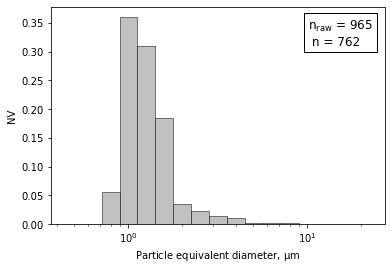

In [45]:
ax=plt.figure()

#Plots a histogram of the binned equivalent diameter data
plt.hist(eq_di[:-1], eq_di, weights = NV_norm, color = 'Silver',\
         edgecolor='k', linewidth=0.5, density = False)
plt.xscale('log')
plt.xlabel("Particle equivalent diameter, $\mathregular{\mu m}$")
plt.ylabel("NV")
ax.text(.72, .84, f"{text} = {total_inputted} \n \
n = {final_particle_number}", horizontalalignment="left", \
        verticalalignment="top", bbox=dict(boxstyle = "square",
                  facecolor = "white"), size = 12)
plt.savefig(f'{file_path}/Output/{file_path}_NV_with_neg.jpg')
  

In [46]:
NV_no_neg_norm = NV_flip/sum(NV_flip) # Normalises so sums to 1
NV_no_neg_norm

array([0.00000000e+00, 0.00000000e+00, 5.57319692e-02, 3.60318857e-01,
       3.09907600e-01, 1.83569501e-01, 3.56397733e-02, 2.19755587e-02,
       1.46322509e-02, 1.11545269e-02, 2.35876496e-03, 2.13742066e-03,
       1.37362019e-03, 7.31999210e-04, 3.87153709e-04, 6.24464150e-05,
       1.85577461e-05])

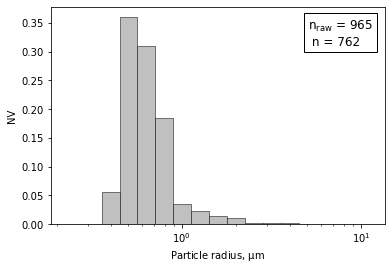

In [47]:
ax = plt.figure()
plt.hist(eq_di[:-1]/2, eq_di/2, weights = NV_no_neg_norm, \
         color = 'Silver', edgecolor='k', linewidth=0.5, \
         density = False) #Plots the binned data
plt.xscale('log')
plt.xlabel("Particle radius, $\mathregular{\mu m}$")
plt.ylabel("NV")
text = "$\mathregular{n_{raw}}$"
ax.text(.72, .84, f"{text} = {total_inputted} \n n = \
{final_particle_number}", horizontalalignment="left", \
        verticalalignment="top", bbox=dict(boxstyle = "square",
                  facecolor = "white"), size = 12)
#plt.xlim([0, 2])
plt.savefig(f'{file_path}/Output/{file_path}_NV.jpg')

In [48]:
# Flips so that the largest values are at the start of the array
NV_no_neg_norm_flip=np.flip(NV_no_neg_norm) 

# Adds to the dataframe stereo
stereo["NV_norm_no_neg"] = NV_no_neg_norm_flip 
stereo.head()

,v bins lower,v bins upper,n bins lower,n bins upper,H_bar,P,Normalised combined,Alpha,NV,NV_norm_no_neg
0,2994.772250,5975.356213,0.630957,1.000000,16.491351,0.775818,0.000215,1.288963,0.000017,0.000019
1,1500.941619,2994.772250,0.398107,0.630957,13.099545,0.141521,0.000614,0.235127,0.000057,0.000062
2,752.252778,1500.941619,0.251189,0.398107,10.405339,0.050599,0.002950,0.041176,0.000351,0.000387
3,377.019489,752.252778,0.158489,0.251189,8.265254,0.019423,0.004811,0.009423,0.000663,0.000732
4,188.957355,377.019489,0.100000,0.158489,6.565325,0.007627,0.007314,0.002380,0.001244,0.001374


In [49]:
# Flips bins around so that the largest 
# values are at the start of the array
r_bins_lower_flip = np.flip(r_bin_lower) 
r_bins_lower_flip = r_bins_lower_flip.reset_index(drop=True)
r_bins_upper_flip = np.flip(r_bin_upper)
r_bins_upper_flip = r_bins_upper_flip.reset_index(drop=True)

In [50]:
stereo["Radius (bins lower)"] = r_bins_lower_flip
stereo["Radius (bins upper)"] = r_bins_upper_flip
stereo.tail()

,v bins lower,v bins upper,n bins lower,n bins upper,H_bar,P,Normalised combined,Alpha,NV,NV_norm_no_neg,Radius (bins lower),Radius (bins upper)
12,0.752253,1.500942,0.002512,0.003981,1.040534,4.769706e-06,0.261293,6.652249e-08,0.280690,0.309908,0.564190,0.710273
13,0.377019,0.752253,0.001585,0.002512,0.826525,1.898848e-06,0.263120,1.806100e-08,0.326349,0.360319,0.448152,0.564190
14,0.188957,0.377019,0.001000,0.001585,0.656532,7.559439e-07,0.083484,4.903720e-09,0.050478,0.055732,0.355980,0.448152
15,0.094703,0.188957,0.000631,0.001000,0.521502,3.009465e-07,0.023312,1.331417e-09,-0.006413,0.000000,0.282765,0.355980
16,0.047464,0.094703,0.000398,0.000631,0.414244,1.198089e-07,0.006481,3.614968e-10,-0.009149,0.000000,0.224608,0.282765


In [51]:
r = eq_di/2 # Converts equivalent diameters to radii
r =np.flip(r[:-1]+(np.diff(r)/2)) # Finds the midpoints of the bins
stereo["Radius midpoints"] = r # Adds midpoints to the dataframe stereo
stereo.head()

,v bins lower,v bins upper,n bins lower,n bins upper,H_bar,P,Normalised combined,Alpha,NV,NV_norm_no_neg,Radius (bins lower),Radius (bins upper),Radius midpoints
0,2994.772250,5975.356213,0.630957,1.000000,16.491351,0.775818,0.000215,1.288963,0.000017,0.000019,8.941802,11.257062,10.099432
1,1500.941619,2994.772250,0.398107,0.630957,13.099545,0.141521,0.000614,0.235127,0.000057,0.000062,7.102726,8.941802,8.022264
2,752.252778,1500.941619,0.251189,0.398107,10.405339,0.050599,0.002950,0.041176,0.000351,0.000387,5.641896,7.102726,6.372311
3,377.019489,752.252778,0.158489,0.251189,8.265254,0.019423,0.004811,0.009423,0.000663,0.000732,4.481517,5.641896,5.061706
4,188.957355,377.019489,0.100000,0.158489,6.565325,0.007627,0.007314,0.002380,0.001244,0.001374,3.559796,4.481517,4.020656


In [52]:
print(f'From the {total_inputted} particles inputted, \
{total_filtered_out} were removed at the first stage of \
filtering. After combining datasets \
{final_particle_number} particles are used in the final distribution.')

From the 965 particles inputted, 72.0 were removed at the first stage of filtering. After combining datasets 762 particles are used in the final distribution.


In [53]:
# Finds the midpoints of the volume bins
v_bin_mid = (stereo["v bins lower"] + stereo["v bins upper"])/2

In [54]:
# Calculates the volume fraction of each particle size
vol_fraction = v_bin_mid*NV

# Normalises so sums to 1
vol_norm = vol_fraction/sum(vol_fraction)

# Adds the normalised volume fraction to the dataframe
stereo["Volume fraction"] = vol_norm

# Flips the array
vol_norm_flip = np.flip(vol_norm)

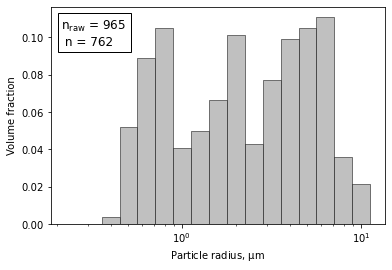

In [55]:
#Plots the binned data against volume fraction
ax = plt.figure()
plt.hist(eq_di[:-1]/2, eq_di/2, weights = vol_norm_flip, color = 'Silver'\
         , edgecolor='k', linewidth=0.5, density= False) 
plt.xscale('log')
plt.xlabel("Particle radius, $\mathregular{\mu m}$")
plt.ylabel("Volume fraction")
text = "$\mathregular{n_{raw}}$"
ax.text(.15, .84, f"{text} = {total_inputted} \n n = \
{final_particle_number}", horizontalalignment="left", \
        verticalalignment="top", bbox=dict(boxstyle = "square",
                  facecolor = "white"), size = 12)
plt.savefig(f'{file_path}/Output/{file_path}_vol.jpg')

In [56]:
data_output.to_csv\
(f'{file_path}/Output/{file_path}_raw_output.csv', \
 index=False)       
stereo.to_csv\
(f'{file_path}/Output/{file_path}_stereo.csv', \
 index=False)  

In [57]:
# Name of the file to copy and save data into
name = 'for_output_data.xlsx' 
xfile = openpyxl.load_workbook(name) # Opens the file
# Saves the file under a new name at the given file path
xfile.save(f'{file_path}/Output/output_calcs.xlsx') 

# Writes dataframe stereo to a new sheet of 
# the spreadheet named 'Data input'
with pd.ExcelWriter(f'{file_path}/Output/output_calcs.xlsx', \
                    engine='openpyxl', mode= 'a') as writer: 
    stereo.to_excel(writer, sheet_name='Data input')